## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns


import statsmodels.api as sm
import statsmodels.stats as sts
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV


pd.set_option('display.max_columns', None)  # Unlimited columns
pd.options.mode.use_inf_as_na = True

/Users/jari/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_data = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv', header=[0], index_col=0)
test_data = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv', header=[0], index_col=[0])
train_labels = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv', header=[0], index_col=[0])

train = train_data.merge(train_labels, on='id', how='inner')
test_data_copy = test_data.copy()

# Data inspection and cleaning

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

In [3]:
from pandas_profiling import ProfileReport
prof = ProfileReport(train)
prof.to_file(output_file='output.html')

In [4]:
prof

In [3]:
train.head(2)

amount_tsh date_recorded   funder  gps_height installer  longitude  \
id                                                                          
69572      6000.0    2011-03-14    Roman        1390     Roman  34.938093   
8776          0.0    2013-03-06  Grumeti        1399   GRUMETI  34.698766   

       latitude  wpt_name  num_private          basin subvillage  region  \
id                                                                         
69572 -9.856322      none            0     Lake Nyasa   Mnyusi B  Iringa   
8776  -2.147466  Zahanati            0  Lake Victoria    Nyamara    Mara   

       region_code  district_code        lga      ward  population  \
id                                                                   
69572           11              5     Ludewa  Mundindi         109   
8776            20              2  Serengeti     Natta         280   

      public_meeting              recorded_by scheme_management scheme_name  \
id                                                                            
69572           True  GeoData Consultants Ltd               VWC       Roman   
8776             NaN  GeoData Consultants Ltd             Other         NaN   

      permit  construction_year extraction_type extraction_type_group  \
id                                                                      
69572  False               1999         gravity               gravity   
8776    True               2010         gravity               gravity   

      extraction_type_class management management_group       payment  \
id                                                                      
69572               gravity        vwc       user-group  pay annually   
8776                gravity        wug       user-group     never pay   

      payment_type water_quality quality_group      quantity quantity_group  \
id                                                                            
69572     annually          soft          good        enough         enough   
8776     never pay          soft          good  insufficient   insufficient   

                     source           source_type source_class  \
id                                                               
69572                spring                spring  groundwater   
8776   rainwater harvesting  rainwater harvesting      surface   

          waterpoint_type waterpoint_type_group status_group  
id                                                            
69572  communal standpipe    communal standpipe   functional  
8776   communal standpipe    communal standpipe   functional

In [5]:
train_labels.head()

status_group
id                   
69572      functional
8776       functional
34310      functional
67743  non functional
19728      functional

In [4]:
train_labels['status_group'].value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
#convert status group label into numerical data
status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
train['status_group_values']=train.status_group.replace(status_group)

In [5]:
train['status_group_values'].head()

KeyError: 'status_group_values'

## Focus on specific features: Category features

In [11]:
train['installer'].value_counts()
# Five main installers are DWE, Government, RWE, Commu, DANIDA

DWE                      17402
Government                1825
RWE                       1206
Commu                     1060
DANIDA                    1050
                         ...  
BEMANDA                      1
WBK                          1
Salehe                       1
KKKT Canal                   1
Cetral government /RC        1
Name: installer, Length: 2145, dtype: int64

In [12]:
# # installer put into different categories
# def clean_installer(train):
#     if train['installer']=='DWE':
#         return 'dwe'
#     elif train['installer']=='Government':
#         return 'government'
#     elif train['installer']=='RWE':
#         return 'rwe'
#     elif train['installer']=='Commu':
#         return 'commu'
#     elif train['installer']=='DANIDA':
#         return 'danida'    
#     else:
#         return 'other'
    
# train['installer']= train.apply(lambda row: clean_installer(row), axis=1)
# test_data_copy['installer']= test_data_copy.apply(lambda row: clean_installer(row), axis=1)

In [13]:
# train['installer'].value_counts()

In [14]:
# installer_piv_tab = pd.pivot_table(train, index = ['installer', 'status_group'], values = 'status_group_values', aggfunc = 'count')
# installer_piv_tab

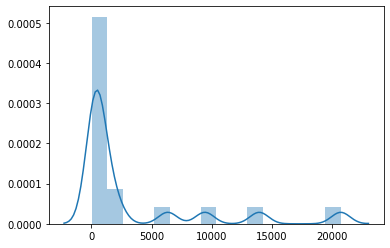

In [15]:
# sns.distplot(installer_piv_tab)

In [16]:
# train['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Icf                          1
Boazi /o                     1
Kcu                          1
Canada Aid                   1
Zaburi And Neig              1
Name: funder, Length: 1897, dtype: int64

In [17]:
# print(train['funder'].unique())

['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']


In [18]:
# divide 'funder' column into 5 categories

In [19]:
# #def funder_cleaning(train):
#     #if train['funder']=='Government Of Tanzania':
#     #    return 'government'
# #     elif train['funder']=='Danida':
#         return 'danida'
#     elif train['funder']=='Hesawa':
#         return 'hesawa'
#     elif train['funder']=='Rwssp':
# #         return 'rwssp'
# #     elif train['funder']=='World Bank':
# #         return 'world_bank'    
#     else:
#         return 'other'
    
# train['funder']= train.apply(lambda row: funder_cleaning(row), axis=1)
# test_data_copy['funder']= test_data_copy.apply(lambda row: funder_cleaning(row), axis=1)

In [20]:
# train['funder'].value_counts()

other         42277
government     9084
danida         3114
hesawa         2202
rwssp          1374
world_bank     1349
Name: funder, dtype: int64

In [21]:
# test_data_copy['funder'].value_counts()

other         10581
government     2215
danida          793
hesawa          580
world_bank      352
rwssp           329
Name: funder, dtype: int64

In [22]:
# funder_piv_tab = pd.pivot_table(train, index=['funder', 'status_group'], values='status_group_values', aggfunc='count')
# funder_piv_tab

status_group_values
funder     status_group                                
danida     functional                              1713
           functional needs repair                  159
           non functional                          1242
government functional                              3720
           functional needs repair                  701
           non functional                          4663
hesawa     functional                               936
           functional needs repair                  232
           non functional                          1034
other      functional                             24540
           functional needs repair                 3019
           non functional                         14718
rwssp      functional                               805
           functional needs repair                  109
           non functional                           460
world_bank functional                               545
           functional needs repair                   97
           non functional                           707

In [24]:
#train['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [25]:
# def scheme_wrangler(row):
#     '''Keep top 5 values and set the rest to 'other'. '''
#     if row['scheme_management']=='VWC':
#         return 'vwc'
#     elif row['scheme_management']=='WUG':
#         return 'wug'
#     elif row['scheme_management']=='Water authority':
#         return 'wtr_auth'
#     elif row['scheme_management']=='WUA':
#         return 'wua'
#     elif row['scheme_management']=='Water Board':
#         return 'wtr_brd'
#     else:
#         return 'other'

# train['scheme_management'] = train.apply(lambda row: scheme_wrangler(row), axis=1)
# test_data_copy['scheme_management'] = test_data_copy.apply(lambda row: scheme_wrangler(row), axis=1)

In [26]:
# scheme_man_piv_tab = pd.pivot_table(train, index=['scheme_management', 'status_group'], values='status_group_values', aggfunc='count')
# scheme_man_piv_tab

status_group_values
scheme_management status_group                                
other             functional                              4627
                  functional needs repair                  513
                  non functional                          3477
vwc               functional                             18960
                  functional needs repair                 2334
                  non functional                         15499
wtr_auth          functional                              1618
                  functional needs repair                  448
                  non functional                          1087
wtr_brd           functional                              2053
                  functional needs repair                  111
                  non functional                           584
wua               functional                              1995
                  functional needs repair                  239
                  non functional                           649
wug               functional                              3006
                  functional needs repair                  672
                  non functional                          1528

# Dealing if Null values and missing data & unneeded columns

In [6]:
train.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [6]:
# Will also drop scheme_name feature because it is missing 47.4 of its values in the test dataset
train.drop(['scheme_name'], axis=1, inplace=True)
test_data_copy.drop(['scheme_name'], axis=1, inplace=True)

In [7]:
# Since public_meeting gives us true of false to rather the well if for public meeting and the
# majority of the vales are true we will fill the 5.9 percent of the missing values with true.
train['public_meeting'] = train['public_meeting'].fillna('True')
test_data_copy['public_meeting'] = test_data_copy['public_meeting'].fillna('True')

In [8]:
# The permit feature is missin a little over 5% of its values so they will be filled with a string
train['permit'] = train['permit'].fillna('Unsure')
test_data_copy['permit'] = test_data_copy['permit'].fillna('Unsure')

In [9]:
# We will drop train waterpoint_type because it is very close to waterpoint_type_group and redundency isn't good
train.drop(['waterpoint_type'], axis=1, inplace=True)
test_data_copy.drop(['waterpoint_type'], axis=1, inplace=True)

In [9]:
train.head(1)

amount_tsh date_recorded funder  gps_height installer  longitude  \
id                                                                        
69572      6000.0    2011-03-14  Roman        1390     Roman  34.938093   

       latitude wpt_name  num_private       basin subvillage  region  \
id                                                                     
69572 -9.856322     none            0  Lake Nyasa   Mnyusi B  Iringa   

       region_code  district_code     lga      ward  population  \
id                                                                
69572           11              5  Ludewa  Mundindi         109   

      public_meeting              recorded_by scheme_management permit  \
id                                                                       
69572           True  GeoData Consultants Ltd               VWC  False   

       construction_year extraction_type extraction_type_group  \
id                                                               
69572               1999         gravity               gravity   

      extraction_type_class management management_group       payment  \
id                                                                      
69572               gravity        vwc       user-group  pay annually   

      payment_type water_quality quality_group quantity quantity_group  \
id                                                                       
69572     annually          soft          good   enough         enough   

       source source_type source_class waterpoint_type_group status_group  
id                                                                         
69572  spring      spring  groundwater    communal standpipe   functional

In [10]:
train['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [11]:
# Dropping the feature recorded_by because it has the same value which is not useful
train.drop(['recorded_by'], axis=1, inplace=True)
test_data_copy.drop(['recorded_by'], axis=1, inplace=True)

In [12]:
train['source'].value_counts()


spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [13]:
train['source_class'].value_counts()


groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [14]:
train['source_type'].value_counts()


spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [15]:
# Source and source type are very similar to the point where it seems some
# of the value groups have been grouped together so we will drop souce 

train.drop(['source'], axis=1, inplace=True)

In [16]:
test_data_copy.drop(['source'],axis=1, inplace=True)

In [17]:
train['water_quality'].value_counts()


soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [18]:
train['quality_group'].value_counts()


good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [19]:
# The features quality_group and water_quality are very smiliar 
#but I feel as though water_quality have better descriptive values so we will drop quality_group

In [20]:
train.drop(['quality_group'], axis=1, inplace=True)
test_data_copy.drop(['quality_group'], axis=1, inplace=True)

In [21]:
train['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [22]:
train['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [23]:
# The payment and payment_type features are identical so I will drop payment

In [24]:
train.drop(['payment'], axis=1, inplace=True)
test_data_copy.drop(['payment'], axis=1, inplace=True)

In [25]:
train['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [26]:
train['extraction_type_class'].value_counts()


gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [27]:
train['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [28]:
# The extraction features are very similar and even seem to be a little mergered so we will drop two of them
train.drop(['extraction_type_group'], axis=1, inplace=True)
test_data_copy.drop(['extraction_type_group'], axis=1, inplace=True)

train.drop(['extraction_type'], axis=1, inplace=True)
test_data_copy.drop(['extraction_type'], axis=1, inplace=True)

In [29]:
train['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [30]:
train['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [31]:
# We will drop management because management_group is the categorized version of the data
train.drop(['management'], axis=1, inplace=True)
test_data_copy.drop(['management'], axis=1, inplace=True)

In [32]:
train_2 = train
train_2.head(1)

amount_tsh date_recorded funder  gps_height installer  longitude  \
id                                                                        
69572      6000.0    2011-03-14  Roman        1390     Roman  34.938093   

       latitude wpt_name  num_private       basin subvillage  region  \
id                                                                     
69572 -9.856322     none            0  Lake Nyasa   Mnyusi B  Iringa   

       region_code  district_code     lga      ward  population  \
id                                                                
69572           11              5  Ludewa  Mundindi         109   

      public_meeting scheme_management permit  construction_year  \
id                                                                 
69572           True               VWC  False               1999   

      extraction_type_class management_group payment_type water_quality  \
id                                                                        
69572               gravity       user-group     annually          soft   

      quantity quantity_group source_type source_class waterpoint_type_group  \
id                                                                             
69572   enough         enough      spring  groundwater    communal standpipe   

      status_group  
id                  
69572   functional

In [33]:
test_data_copy_2 = test_data_copy
test_data_copy_2.head(1)

amount_tsh date_recorded funder  gps_height installer  longitude  \
id                                                                        
50785         0.0    2013-02-04   Dmdd        1996      DMDD  35.290799   

       latitude                 wpt_name  num_private     basin subvillage  \
id                                                                           
50785 -4.059696  Dinamu Secondary School            0  Internal     Magoma   

        region  region_code  district_code    lga    ward  population  \
id                                                                      
50785  Manyara           21              3  Mbulu  Bashay         321   

      public_meeting scheme_management permit  construction_year  \
id                                                                 
50785           True        Parastatal   True               2012   

      extraction_type_class management_group payment_type water_quality  \
id                                                                        
50785                 other       parastatal    never pay          soft   

       quantity quantity_group           source_type source_class  \
id                                                                  
50785  seasonal       seasonal  rainwater harvesting      surface   

      waterpoint_type_group  
id                           
50785                 other

In [34]:
test_data_copy_2.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management_group',
       'payment_type', 'water_quality', 'quantity', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group'],
      dtype='object')

In [61]:
clean_data_geo(test_data_copy)

In [49]:
# def cat_construction(x):
#     if x['construction_year'] >= int(1960) and x['construction_year'] < int(1970):
#         return '60s'
#     elif x['construction_year'] >= int(1970) and x['construction_year'] < int(1980):
#         return '70s'
#     elif x['construction_year'] >= int(1980) and x['construction_year'] < int(1990):
#         return '80s'
#     elif x['construction_year'] >= int(1990) and x['construction_year'] < int(2000):
#         return '90s'
#     elif x['construction_year'] >= int(2000) and x['construction_year'] < int(2010):
#         return '00s'
#     elif x['construction_year'] >= int(2010):
#         return '10s'
#     else:
#         return 'unknown'
    
# train['construction_year'] = train.apply(lambda x: cat_construction(x), axis=1)
# test_data_copy['construction_year'] = test_data_copy.apply(lambda x: cat_construction(x), axis=1)

In [50]:
# train['construction_year'].value_counts()

unknown    20709
00s        15330
90s         7678
80s         5578
10s         5161
70s         4406
60s          538
Name: construction_year, dtype: int64

In [ ]:
# # Getting rid of outliers for long and lat
# train_1 = train_1[(train_1['latitude'] >= np.percentile(train_1['latitude'], 0.05)) & 
#  (train_1['latitude'] < np.percentile(train_1['latitude'], 99.95)) &
#  (train_1['longitude'] >= np.percentile(train_1['longitude'], 0.05)) & 
#  (train_1['longitude'] <= np.percentile(train_1['longitude'], 99.95))]

In [61]:
train.shape

(59400, 24)

In [55]:
test_data_copy.shape

(14850, 23)

# EDA

### 1) Who are the majority funders and managers who are in charge of the wells?

Text(0.5, 0, 'Management')

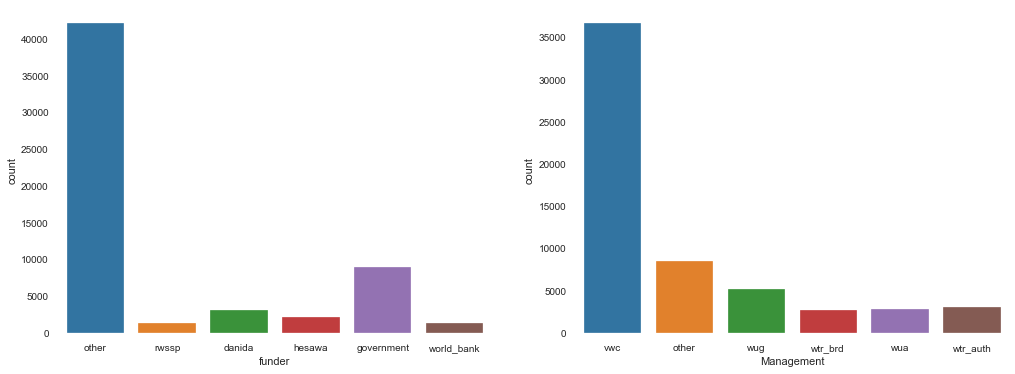

In [99]:
# f, axes = plt.subplots(ncols=2,figsize=(17,6))

#sns.countplot(x='funder', ax=axes[0],data=train)

# sns.countplot(x='scheme_management',ax=axes[1],data=train)
# plt.xticks(rotation=360)
# plt.xlabel('Management')

In [103]:
#train['funder'].value_counts(normalize=True)

other         0.711734
government    0.152929
danida        0.052424
hesawa        0.037071
rwssp         0.023131
world_bank    0.022710
Name: funder, dtype: float64

In [104]:
#train['scheme_management'].value_counts(normalize=True)

vwc         0.619411
other       0.145067
wug         0.087643
wtr_auth    0.053081
wua         0.048535
wtr_brd     0.046263
Name: scheme_management, dtype: float64

- As for the funding for the wells over 70% of the funders are not the one the larger entities that are funding the wells.  This could be a good predictor of the funtionality of the wells.  Also 60% of the upkeeping and managment if being done by Village Water Committee (VWC).  This is a government owned and funded entitiy

## 2) Is there any area with an increase of non functional or repair needing wells?

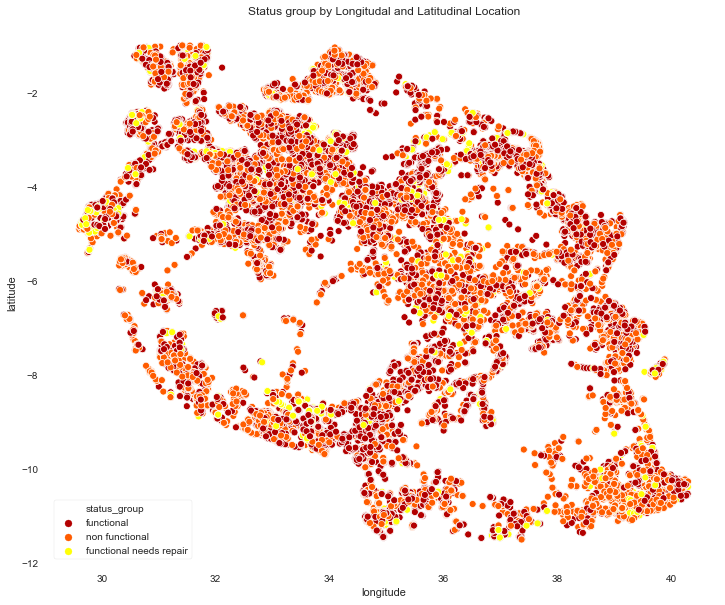

In [163]:
#plt.figure(figsize=(12,10))
#sns.scatterplot(train_1['longitude'], train_1['latitude'], hue=train_1['status_group'], palette='hot')
#plt.legend(loc='lower left')
#plt.title("Status group by Longitudal and Latitudinal Location");

In [63]:
#train['status_group_values'].value_counts(normalize=True)

2    0.543081
0    0.384242
1    0.072677
Name: status_group_values, dtype: float64

- From the graph above there seems to be lots of non functional and repair needing wells everywhere in the county. But there is an influx around the cost of the country.  There also seems to be gaps in well and or data in central and southern Tanzina

# 3) When were the majority of the wells built?

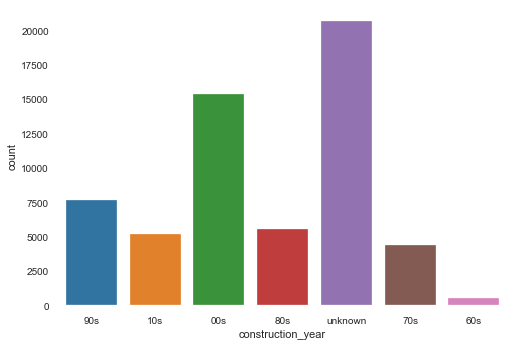

In [154]:
#sns.countplot(train['construction_year']);

In [167]:
train['construction_year'].value_counts(normalize=True)

unknown    0.348636
00s        0.258081
90s        0.129259
80s        0.093906
10s        0.086886
70s        0.074175
60s        0.009057
Name: construction_year, dtype: float64

In [134]:
corr = train.corr()
corr

amount_tsh  population  status_group_values
amount_tsh             1.000000    0.016288             0.053702
population             0.016288    1.000000             0.017759
status_group_values    0.053702    0.017759             1.000000

In [133]:
sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);

(59400, 20)

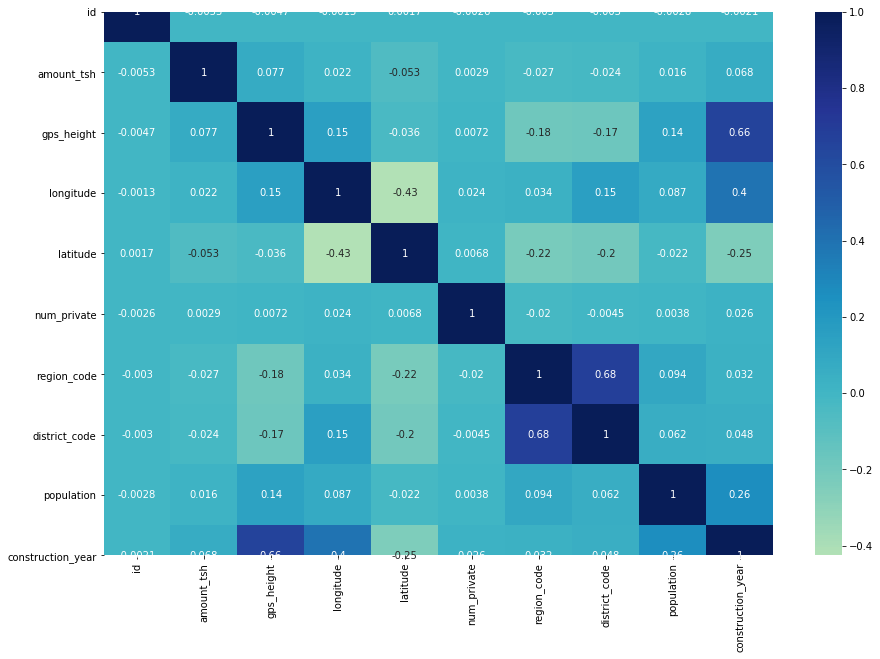

## Modeling

In [35]:
train_2.nunique().sort_values(ascending = True)

status_group                 3
source_class                 3
permit                       3
public_meeting               3
quantity_group               5
quantity                     5
management_group             5
waterpoint_type_group        6
source_type                  7
payment_type                 7
extraction_type_class        7
water_quality                8
basin                        9
scheme_management           12
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 65
amount_tsh                  98
lga                        125
date_recorded              356
population                1049
funder                    1897
ward                      2092
installer                 2145
gps_height                2428
subvillage               19287
wpt_name                 37400
longitude                57516
latitude                 57517
dtype: int64

In [36]:
train_num_2 = train_2.select_dtypes(include = np.number).copy()
train_num_2.head(1)

amount_tsh  gps_height  longitude  latitude  num_private  region_code  \
id                                                                             
69572      6000.0        1390  34.938093 -9.856322            0           11   

       district_code  population  construction_year  
id                                                   
69572              5         109               1999

In [37]:
# Encode features with more then < 50 unique values, numberical columns to that dataframe
X_train_2 = train_2.loc[:, train_2.nunique().sort_values() < 50]
print('X_train_2:', X_train_2.shape)
X_train_2.head()

X_train_2: (59400, 17)


basin   region  region_code  district_code  \
id                                                                    
69572               Lake Nyasa   Iringa           11              5   
8776             Lake Victoria     Mara           20              2   
34310                  Pangani  Manyara           21              4   
67743  Ruvuma / Southern Coast   Mtwara           90             63   
19728            Lake Victoria   Kagera           18              1   

      public_meeting scheme_management permit extraction_type_class  \
id                                                                    
69572           True               VWC  False               gravity   
8776            True             Other   True               gravity   
34310           True               VWC   True               gravity   
67743           True               VWC   True           submersible   
19728           True               NaN   True               gravity   

      management_group payment_type water_quality      quantity  \
id                                                                
69572       user-group     annually          soft        enough   
8776        user-group    never pay          soft  insufficient   
34310       user-group   per bucket          soft        enough   
67743       user-group    never pay          soft           dry   
19728            other    never pay          soft      seasonal   

      quantity_group           source_type source_class waterpoint_type_group  \
id                                                                              
69572         enough                spring  groundwater    communal standpipe   
8776    insufficient  rainwater harvesting      surface    communal standpipe   
34310         enough                   dam      surface    communal standpipe   
67743            dry              borehole  groundwater    communal standpipe   
19728       seasonal  rainwater harvesting      surface    communal standpipe   

         status_group  
id                     
69572      functional  
8776       functional  
34310      functional  
67743  non functional  
19728      functional

In [38]:
cat_cols_train_2 = list(X_train_2.select_dtypes(['object']).columns.values)

X_categorical_train_2 = X_train_2[cat_cols_train_2].apply(lambda x: x.astype('category').cat.codes)
X_categorical_train_2.head()

basin  region  public_meeting  scheme_management  permit  \
id                                                                
69572      1       3               1                  7       0   
8776       4       9               2                  2       1   
34310      5       8               1                  7       1   
67743      7      12               1                  7       1   
19728      4       4               1                 -1       1   

       extraction_type_class  management_group  payment_type  water_quality  \
id                                                                            
69572                      0                 4             0              6   
8776                       0                 4             2              6   
34310                      0                 4             5              6   
67743                      5                 4             2              6   
19728                      0                 1             2              6   

       quantity  quantity_group  source_type  source_class  \
id                                                           
69572         1               1            6             0   
8776          2               2            3             1   
34310         1               1            1             1   
67743         0               0            0             0   
19728         3               3            3             1   

       waterpoint_type_group  status_group  
id                                          
69572                      1             0  
8776                       1             0  
34310                      1             0  
67743                      1             2  
19728                      1             0

In [39]:
X_train_2_select = train_num_2.join(X_categorical_train_2)
X_train_2_select.shape

(59400, 24)

In [40]:
X_train_2_select.head(1)

amount_tsh  gps_height  longitude  latitude  num_private  region_code  \
id                                                                             
69572      6000.0        1390  34.938093 -9.856322            0           11   

       district_code  population  construction_year  basin  region  \
id                                                                   
69572              5         109               1999      1       3   

       public_meeting  scheme_management  permit  extraction_type_class  \
id                                                                        
69572               1                  7       0                      0   

       management_group  payment_type  water_quality  quantity  \
id                                                               
69572                 4             0              6         1   

       quantity_group  source_type  source_class  waterpoint_type_group  \
id                                                                        
69572               1            6             0                      1   

       status_group  
id                   
69572             0

# Model

In [41]:
target = X_train_2_select['status_group']
train = X_train_2_select.drop('status_group', axis=1)

In [42]:
# Decision Tree
clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            train, target,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


array([0.75212121, 0.74580808, 0.74545455])

In [43]:
X_test_num = test_data_copy_2.select_dtypes(include = np.number).copy()

In [46]:
# Try with test data


# clf.fit(X_train, y_train)

X_test_2_select = test_data_copy_2.loc[:, test_data_copy_2.nunique().sort_values() < 50]

In [47]:
cat = list(X_test_2_select.select_dtypes(['object']).columns.values)
X_test_cat = X_test_2_select[cat].apply(lambda x: x.astype('category').cat.codes)

X_test_sel = X_test_num.join(X_test_cat)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    train, target, test_size=0.2)

In [49]:
X_test_num = test_data_copy_2.select_dtypes(include = np.number).copy()

In [50]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/jari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8023569023569024

In [51]:
cat = list(X_test_2_select.select_dtypes(['object']).columns.values)
X_test_cat = X_test_2_select[cat].apply(lambda x: x.astype('category').cat.codes)

X_test_sel = X_test_num.join(X_test_cat)

In [54]:
y_predict = clf.predict(X_test_sel)

In [56]:
y_predict = pd.DataFrame(data = y_predict, index=X_test_sel.index.values, columns=['status_group'])
y_predict.head()

status_group
50785             0
51630             0
17168             0
45559             2
49871             0